<a href="https://colab.research.google.com/github/herdiadam/Project-Deep-Learning/blob/main/Network_Attack_Classification_CNN_LSTM_HIKARI2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset

In [ ]:
df = pd.read_csv('ALLFLOWMETER_HIKARI2021.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,0,0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200.0,65160.0,0.0,Bruteforce-XML,1.0
1,1,1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200.0,65160.0,0.0,Bruteforce-XML,1.0
2,2,2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200.0,65160.0,0.0,Bruteforce-XML,1.0
3,3,3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200.0,65160.0,0.0,Bruteforce-XML,1.0
4,4,4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200.0,65160.0,0.0,Bruteforce-XML,1.0


# Preprocessing Dataset

In [ ]:
X = df.drop(['Label', 'traffic_category'], axis=1, errors='ignore')
y = df['Label']

data = pd.concat([X, y], axis=1)

data = data.dropna()

X = data.drop(['Label'], axis=1)
y = data['Label']

le = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_res = X_train_res.reshape(X_train_res.shape[0], X_train.shape[1], 1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# Arsitektur Model

In [ ]:
def create_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # CNN Layer
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # LSTM Layer
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Dense Layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_model((X_train.shape[1], 1))

# Training Model

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_res, y_train_res,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.8420 - loss: 0.3981 - val_accuracy: 0.9992 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 2/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 60s 78ms/step - accuracy: 0.9582 - loss: 0.1333 - val_accuracy: 0.9989 - val_loss: 0.0036 - learning_rate: 1.0000e-04
Epoch 3/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 78s 72ms/step - accuracy: 0.9804 - loss: 0.0694 - val_accuracy: 0.9979 - val_loss: 0.0073 - learning_rate: 1.0000e-04
Epoch 4/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - accuracy: 0.9887 - loss: 0.0374 - val_accuracy: 0.9984 - val_loss: 0.0057 - learning_rate: 1.0000e-04
Epoch 5/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.9928 - loss: 0.0285 - val_accuracy: 0.9989 - val_loss: 0.0032 - learning_rate: 1.0000e-04
Epoch 6/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - accuracy: 0.9951 - loss: 0.0199 - val_accuracy: 0.9995 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 7/50
772/772 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/ste

# Visualisasi dan Evaluasi Model

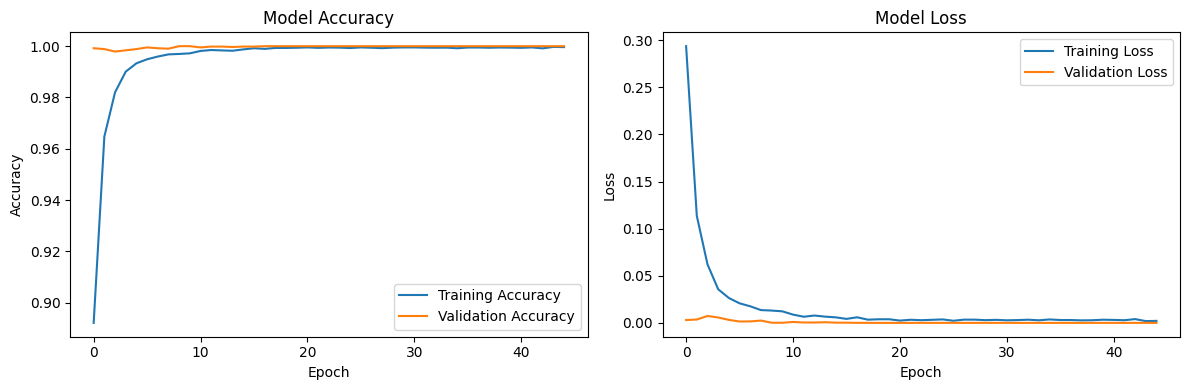

190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step


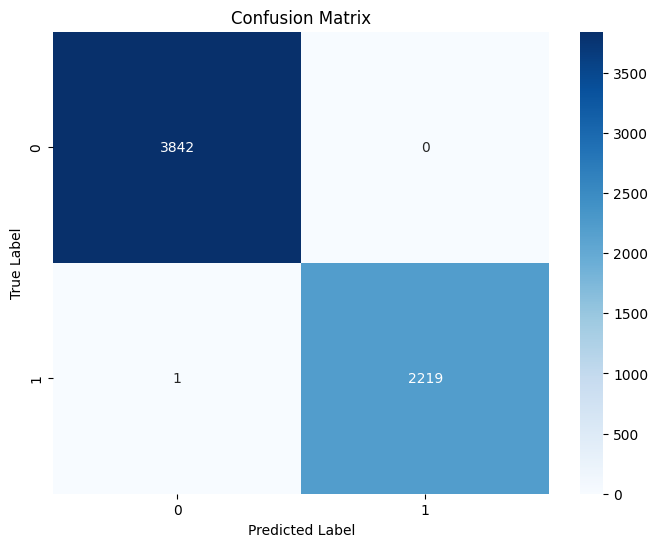


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3842
         1.0       1.00      1.00      1.00      2220

    accuracy                           1.00      6062
   macro avg       1.00      1.00      1.00      6062
weighted avg       1.00      1.00      1.00      6062



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Result

In [ ]:
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred_classes.flatten(),
    'Probability': y_pred.flatten()
})
results_df.to_csv('CL_prediction_results.csv', index=False)